# Set up environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Test if GPU is available
# Note that CUDA below 12.1 can have bugs
import torch
print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0))
print(torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
12.1


In [3]:
#%% import libraries
import os
from collections import defaultdict
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
import numpy as np
import numpy.random
from numpy.fft import fft as fft
from numpy.fft import ifft as ifft
import pickle
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import scipy.stats
from scipy.stats import wilcoxon, chi2
import scipy.interpolate 
import scipy.signal
from scipy import linalg
from scipy.special import rel_entr
from tqdm import tqdm
import pandas as pd
import joblib
import logging

import statsmodels.api as sm
import statsmodels.genmod.generalized_linear_model as smm

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim

In [4]:
# import my code
from FCGPFA import gpfa_poisson_fix_weights, make_4d_diagonal, get_K
from FCGPFA import conv, conv_subspace
import utility_functions as utils
import GLM
from DataLoader import Allen_dataset, Allen_dataloader_multi_session
from model_trainer import Trainer

/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [19]:
# Load from toy dataloader with two sessions
if sys.platform == 'linux':
    data_path = '/home/qix/user_data/allen_spike_trains/two_session_toy_dataloader.joblib'
else:
    data_path = 'D:/ecephys_cache_dir/two_session_toy_dataloader.joblib'
cross_session_dataloader = joblib.load(data_path)

# Train a model

In [43]:
ckp_path = '/home/qix/user_data/VAETransformer_checkpoint'

torch.manual_seed(0)
np.random.seed(0)

params = {
    # B-spline basis
    'num_B_spline_basis': 20,
    # Transformer VAE's settings
    'downsample_factor': 10,
    'transformer_num_layers': 2,
    'transformer_d_model': 128,
    'transformer_dim_feedforward': 512,
    'transformer_vae_output_dim': 16,
    'transformer_dropout': 0.0,
    'transformer_nhead': 2,
    'stimulus_nfactor': 4,
    'stimulus_decoder_inter_dim_factor': 4,
    'beta': 0.1,
    # Coupling's settings
    'coupling_basis_peaks_max': 20,
    'coupling_basis_num': 3,
    'coupling_nsubspace': 1,
    'use_self_coupling': True,
    # Coupling strength latent's settings
    'K_sigma2': 1.0,
    'K_tau': 100,
    'coupling_strength_nlatent': 1,
    # Penalty settings
    'penalty_overlapping': None, 
    # Training settings
    'batch_size': 64,
    'sample_latent': False,
    'lr': 1e-3,
    'epoch_warm_up': 10,
    'epoch_patience': 5,
    'epoch_max': 50,
    # Currently not used
    'weight_decay': 0.0,
    'lr_transformer': 0.0001,
    'lr_sti': 0.01,
    'lr_cp': 0.01,
}

trainer = Trainer(cross_session_dataloader, ckp_path, params)
trainer.train(
    include_stimulus=True,
    include_coupling=False,
    fix_stimulus=False,
    fix_latents=True,
    verbose=True,
)
# trainer.train(
#     include_stimulus=True,
#     include_coupling=True,
#     fix_stimulus=False,
#     fix_latents=True,
#     verbose=True,
# )

Total sessions: 2, Batch size: 64, Train set size: 266, Val set size: 38, Test set size: 76
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 2, 'stimulus_nfactor': 4, 'stimulus_decoder_inter_dim_factor': 4, 'beta': 0.1, 'coupling_basis_peaks_max': 20, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_overlapping': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 10, 'epoch_patience': 5, 'epoch_max': 50, 'weight_decay': 0.0, 'lr_transformer': 0.0001, 'lr_sti': 0.01, 'lr_cp': 0.01}
Model initialized. Training on cuda


100%|██████████| 38/38 [00:10<00:00,  3.71it/s]


Epoch 1/50, Train Loss: 4.6206, Test Loss: 2.3161


100%|██████████| 38/38 [00:10<00:00,  3.68it/s]


Epoch 2/50, Train Loss: 4.5734, Test Loss: 2.2962


100%|██████████| 38/38 [00:10<00:00,  3.69it/s]


Epoch 3/50, Train Loss: 4.5454, Test Loss: 2.2884


 39%|███▉      | 15/38 [00:03<00:06,  3.51it/s]

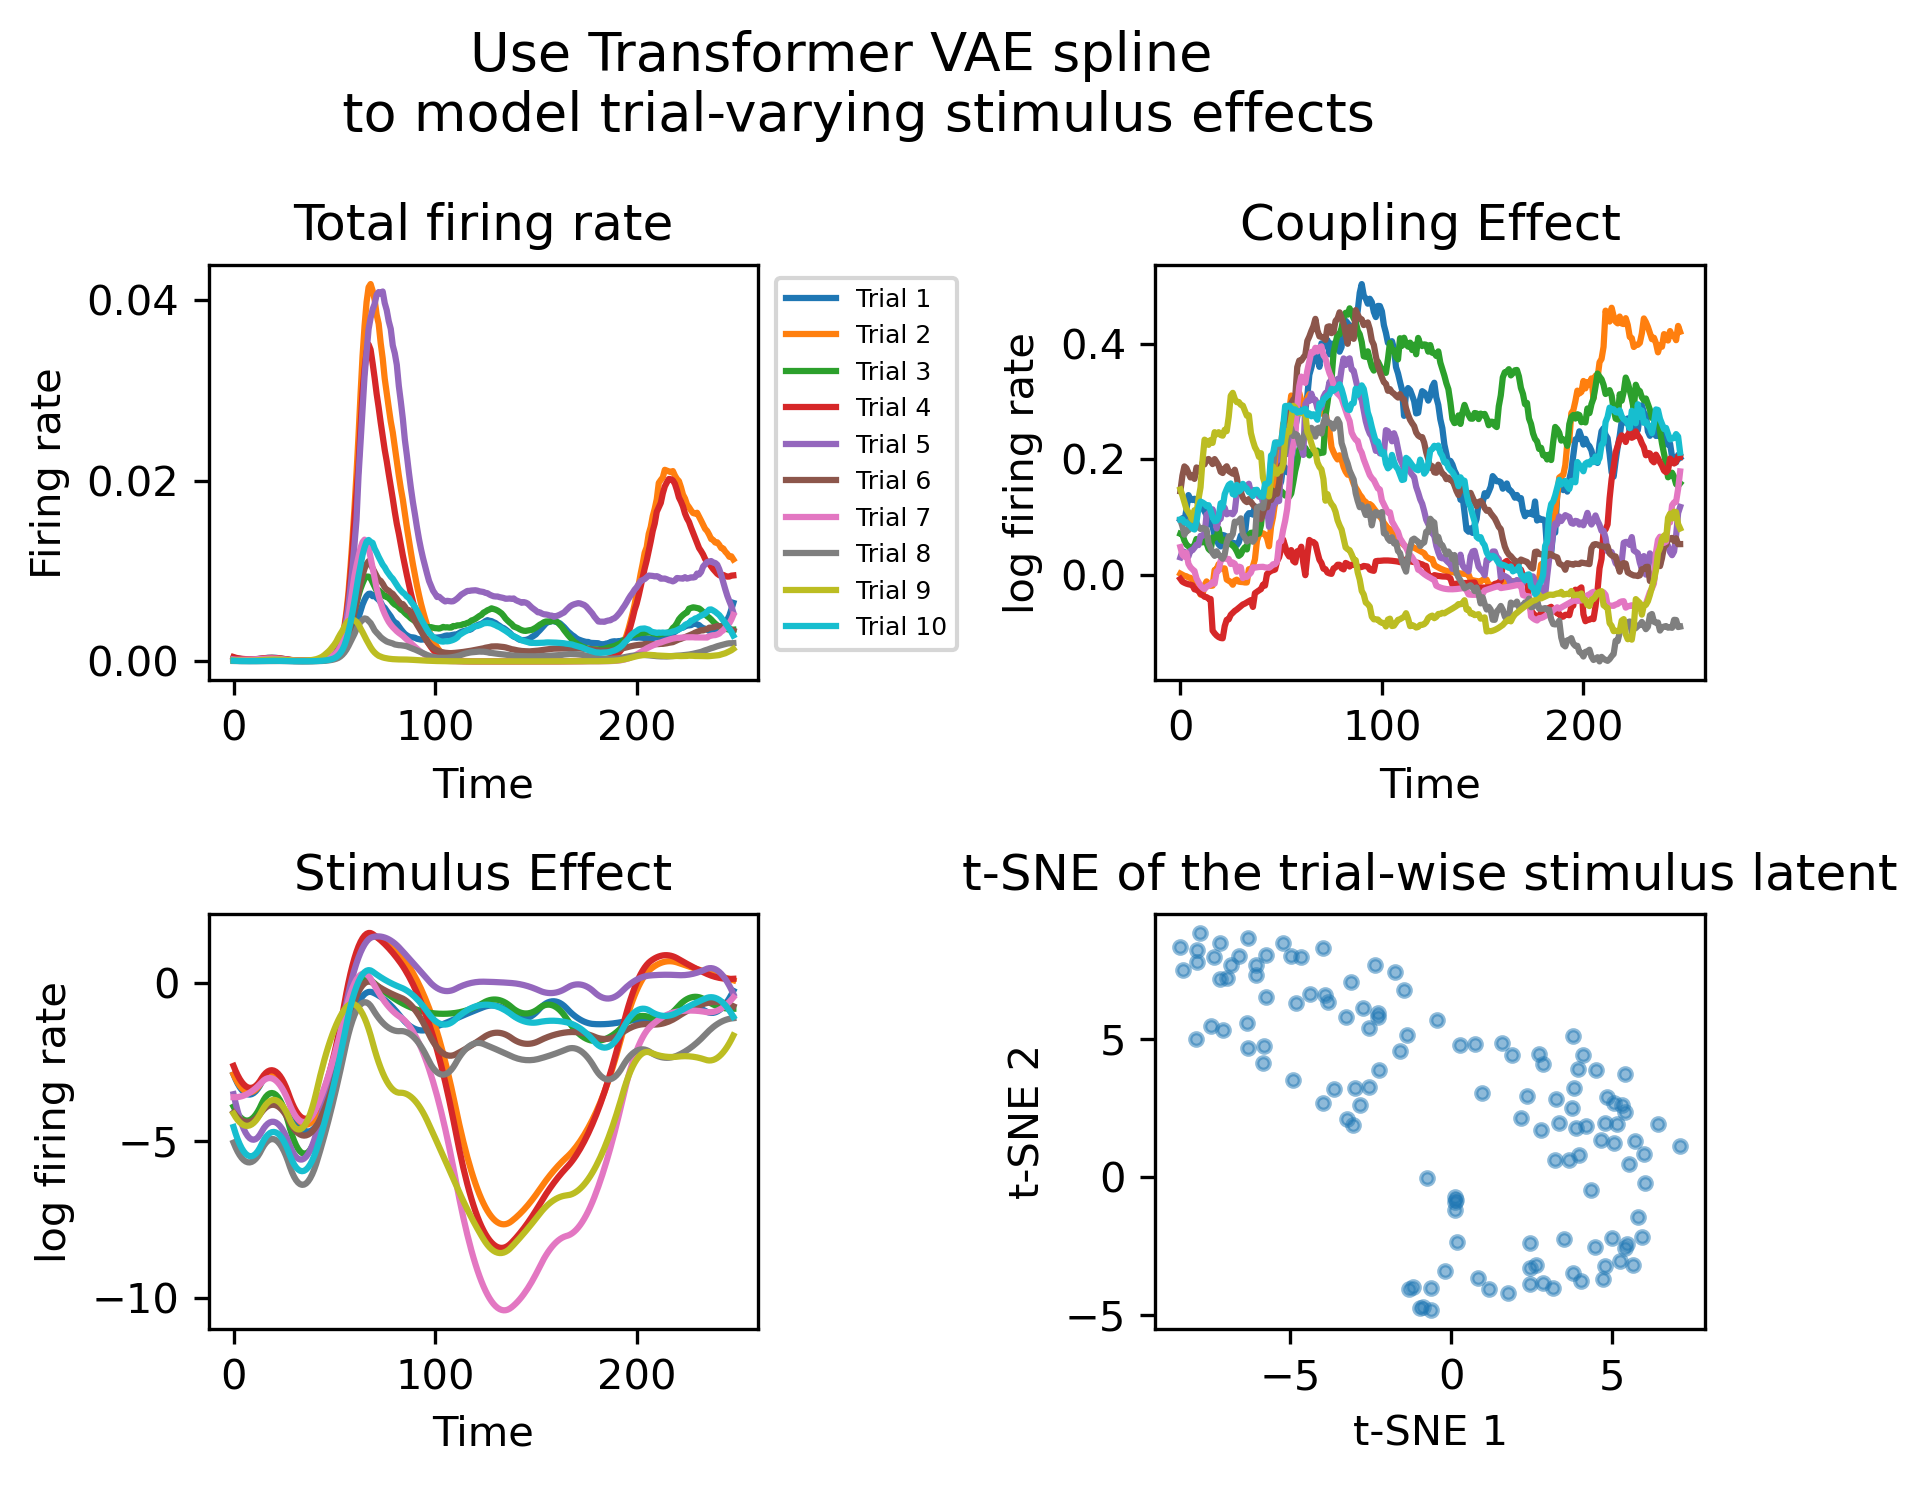

In [263]:
trial_indices = np.arange(100, 110)
neuron_idx = 150

firing_rate_test, sti_mu_test, sti_logvar_test = trainer.predict(
    dataset='test',
    batch_indices=[0,1,2,3,4],
    return_torch=True, 
    include_stimulus=True,
    include_coupling=False, 
    fix_stimulus=False,
    fix_latents=True, 
)

# Create a 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(6, 5) ,dpi=300)
fig.suptitle('Use Transformer VAE spline \n to model trial-varying stimulus effects', fontsize=13)

# Plot total firing rate
axes[0,0].plot(np.exp(firing_rate_test[:, neuron_idx, trial_indices].numpy().T))
axes[0,0].set_title('Total firing rate')
axes[0,0].set_xlabel('Time')
axes[0,0].set_ylabel('Firing rate')
axes[0,0].legend([f'Trial {i+1}' for i in range(trainer.model.firing_rates_stimulus.shape[2])], 
                 bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=6)

# Plot coupling effect
# axes[0,1].plot(trainer.model.firing_rates_coupling[:, neuron_idx, trial_indices].cpu().numpy().T)
# axes[0,1].set_title('Coupling Effect')
# axes[0,1].set_xlabel('Time')
# axes[0,1].set_ylabel('log firing rate')

# Plot stimulus effect
# axes[1,0].plot(trainer.model.firing_rates_stimulus[:, neuron_idx, trial_indices].cpu().numpy().T)
# axes[1,0].set_title('Stimulus Effect')
# axes[1,0].set_xlabel('Time')
# axes[1,0].set_ylabel('log firing rate')

# Plot t-SNE in the last subplot
tsne = TSNE(n_components=2, random_state=42)
sti_mu_test_np = sti_mu_test.detach().cpu().numpy() if torch.is_tensor(sti_mu_test) else sti_mu_test
sti_mu_test_tsne = tsne.fit_transform(sti_mu_test_np)
axes[1,1].scatter(sti_mu_test_tsne[:, 0], sti_mu_test_tsne[:, 1], alpha=0.5, marker='.')
axes[1,1].set_title('t-SNE of the trial-wise stimulus latent')
axes[1,1].set_xlabel('t-SNE 1')
axes[1,1].set_ylabel('t-SNE 2')

plt.tight_layout()
# plt.savefig('Figure/all_effects_and_tsne0.pdf', bbox_inches='tight', dpi=300)